In [21]:
import tensorflow as tf
print(tf.__version__)
import os
# asher note: macOS workaround
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import glob
from os.path import dirname, abspath
import sys
import datetime
import random
import numpy as np
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('QT5Agg')
from project_assets.cucu_classes import *
from cucu_config import cucuConf as config
from PIL import Image 
%load_ext autoreload
%autoreload 2

import json


1.12.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# from cucu_realDatasetClass import *
ROOT_DIR = dirname(os.getcwd())
print(ROOT_DIR)
# create a container for training result per exexution of cucu_train.py
CONTAINER_ROOT_DIR = ROOT_DIR + "/cucu_train/trainResultContainers/"
now = datetime.datetime.now()

#
CURRENT_CONTAINER_DIR = CONTAINER_ROOT_DIR + "train_results_2019-01-20 20:19:20.984692"
# CURRENT_CONTAINER_DIR = CONTAINER_ROOT_DIR +"train_results_" + str(now)
os.chmod(ROOT_DIR, mode=0o777)
# create centralized class for used paths during training
cucuPaths = project_paths(
    projectRootDir=ROOT_DIR,
    TensorboardDir=        os.path.join(CURRENT_CONTAINER_DIR, "TensorBoardGraphs"),
    trainedModelsDir=      os.path.join(CURRENT_CONTAINER_DIR, "trained_models"),
    visualizeEvaluationsDir = os.path.join(CURRENT_CONTAINER_DIR, "visualizeEvaluations"),
    cocoModelPath=         os.path.join(ROOT_DIR, "mask_rcnn_coco.h5"),
    trainDatasetDir=       os.path.join(ROOT_DIR, "cucu_train/project_dataset/real/512/augmented"),
    valDatasetDir=         os.path.join(ROOT_DIR, "cucu_train/project_dataset/real/512/validation"),
    testDatasetDir=        os.path.join(ROOT_DIR, "cucu_train/project_dataset/real/512/validation"),
    trainResultContainer=  CURRENT_CONTAINER_DIR,
    trainOutputLog      =  CURRENT_CONTAINER_DIR

)

# Import Mask RCNN
sys.path.append(cucuPaths.projectRootDir)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import sys
print(sys.version)

# try:
#     original_umask = os.umask(0)
#     os.makedirs(cucuPaths.trainedModelsDir, mode=0o777)
#     os.makedirs(cucuPaths.visualizeEvaluationsDir, mode=0o777)

# finally:
#     os.umask(original_umask)

/home/simon/Mask_RCNN
3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]


In [27]:
#create configurations for model instentiating
cucuConf.display()

#prepare source objects for current container
# from randomColorObjects import randomColorObject, toGray
# from shutil import copyfile, copytree

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=cucuPaths.TensorboardDir)

# load initial weights

# weightPath="/home/simon/Mask_RCNN/cucu_train/trainResultContainers/train_results_2019-01-15 22:07:14.522361/trained_models/cucuWheights_2019-01-16 16:05:30.280801.h5"
# model.load_weights(weightPath, by_name=True)
# print("loaded weights from path:", weightPath)

#create directory to hold inside samples of images we pass to model during training
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/SamplesOfTrainDataset")

# Validation dataset
dataset_val = realDataset()
dataset_val.load_dataset(os.path.join(cucuPaths.valDatasetDir, "annotations.json"), cucuPaths.valDatasetDir)
dataset_val.prepare()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
BOUNDING_DELTA                 0.2
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EPOCHS                         30
EPOCHS_ROUNDS                  5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mr

(512, 853, 3)
figure size: 14
(512, 853, 3)
figure size: 14
(512, 853, 3)
figure size: 14
(512, 853, 3)
figure size: 14
(512, 853, 3)
figure size: 14


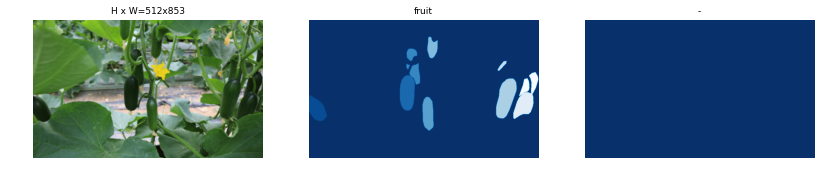

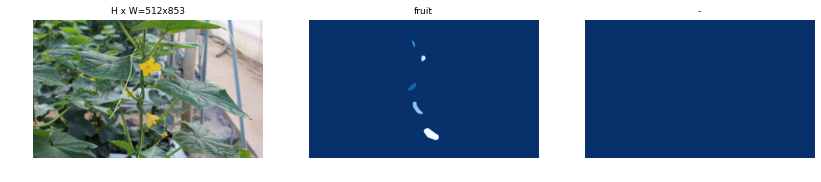

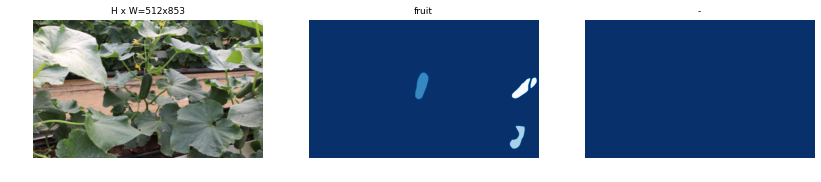

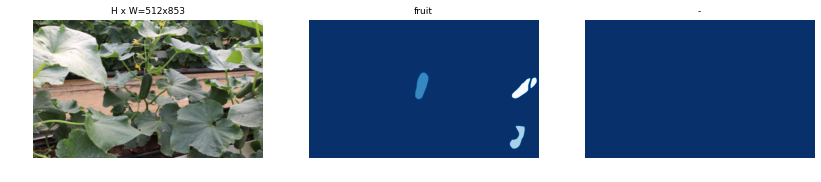

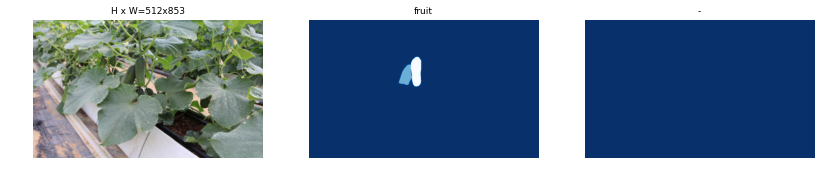

In [28]:
#show n random image&mask train examples
n = 5
image_ids = np.random.choice(dataset_val.image_ids, n)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names, None, 2)

In [29]:
class InferenceConfig(cucumberConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=cucuPaths.TensorboardDir)

# Load trained weights
list_of_trained_models = glob.glob(cucuPaths.trainedModelsDir +'/*')
latest_trained_model = max(list_of_trained_models, key=os.path.getctime)

print("Loading weights from ", latest_trained_model)
model.load_weights(latest_trained_model, by_name=True)

Loading weights from  /home/simon/Mask_RCNN/cucu_train/trainResultContainers/train_results_2019-01-20 20:19:20.984692/trained_models/cucuWheights_2019-01-21 06:55:48.199322.h5


Processing 1 images
image                    shape: (512, 853, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  853.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
figure size: 14
['BG', 'fruit']
Processing 1 images
image                    shape: (512, 853, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  853.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
figure size: 14
['BG', 'fruit']
Processing 1 images
image                    shape: (512, 853, 3)         min:    0.00000  max:  255.00000  uint8
molded_images     

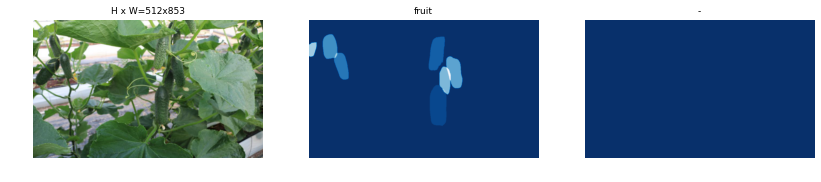

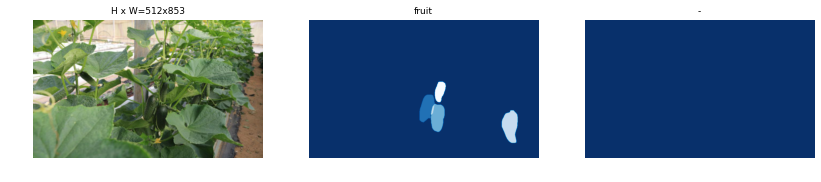

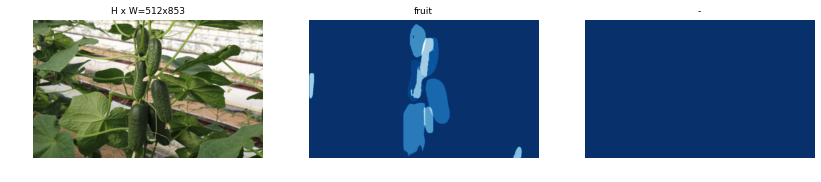

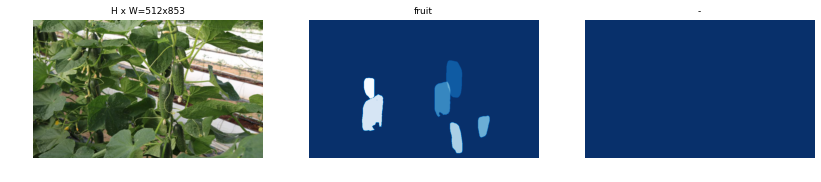

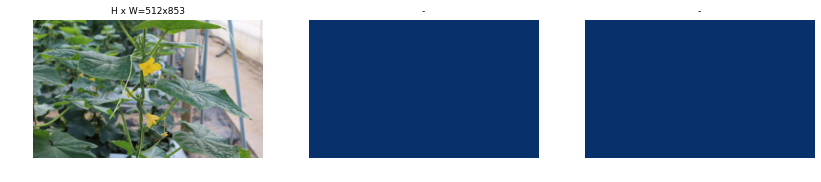

In [30]:
# DISPLAY_TOP_MASKS
#create container directories per function calls from Visualize module
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/display_top_masks")
tests_location = cucuPaths.testDatasetDir

n = 5
for filename in sorted(os.listdir(tests_location))[:n]: 
    testImage = os.path.join(tests_location,filename)
    try:
        t = cv2.cvtColor(cv2.imread(testImage), cv2.COLOR_BGR2RGB)
    except Exception as e:
        print("error: {}, \n probably a non image file is in the directory".format(e))
        continue
    results = model.detect([t], verbose=1)
    r = results[0]
    # visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'] ,dataset_train.class_names, r['scores'], ax=get_ax())
    visualize.display_top_masks(t, r['masks'], r['class_ids'] ,dataset_val.class_names, savePath=None )

    t= dataset_val.class_names
    print(t)

image ID: coco.2 (2) 
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:   49.00000  max:  360.00000  int32
gt_mask                  shape: (512, 512, 8)         min:    0.00000  max:    1.00000  bool
image_id  2 
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 8)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (8,)                  min:    1.00000  max:    1.00000  int32
bbo

/home/simon/anaconda3/envs/cleanEnv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/simon/anaconda3/envs/cleanEnv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  226.00000  max:  432.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  bool
image_id  18 
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 3)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:  226.00000  max:  432.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.76777  max:    2.98311  float64
positive_anchors         shape: (3, 4)                min:  210.74517  max:  429.25483  float64
negative_anchors         shape: (253, 4)    

/home/simon/anaconda3/envs/cleanEnv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:    0.00000  max:  511.00000  int32
gt_mask                  shape: (512, 512, 9)         min:    0.00000  max:    1.00000  bool
image_id  5 
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 9)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (9,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (9, 4)                min:    0.00000  max:  511.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -2.96717  max:    2.50000  float64
positive_anchors         shape: (9, 4)                min:    0.00000  max:  512.00000  float64
negative_anchors         shape: (247, 4)     

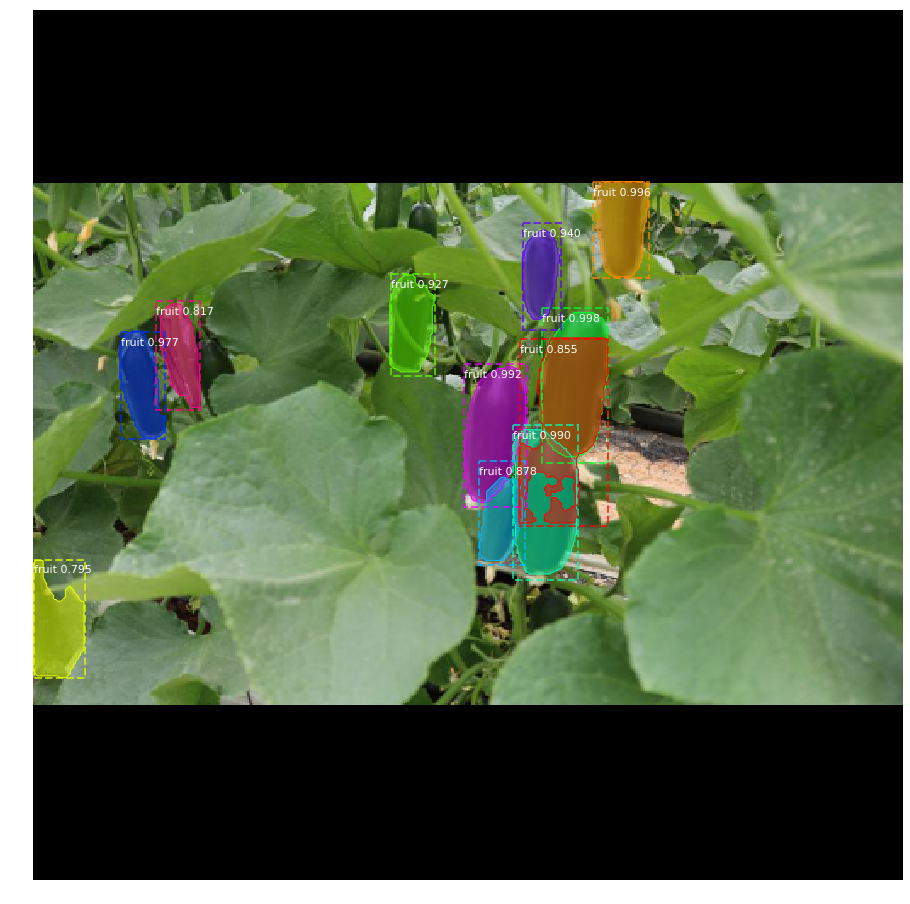

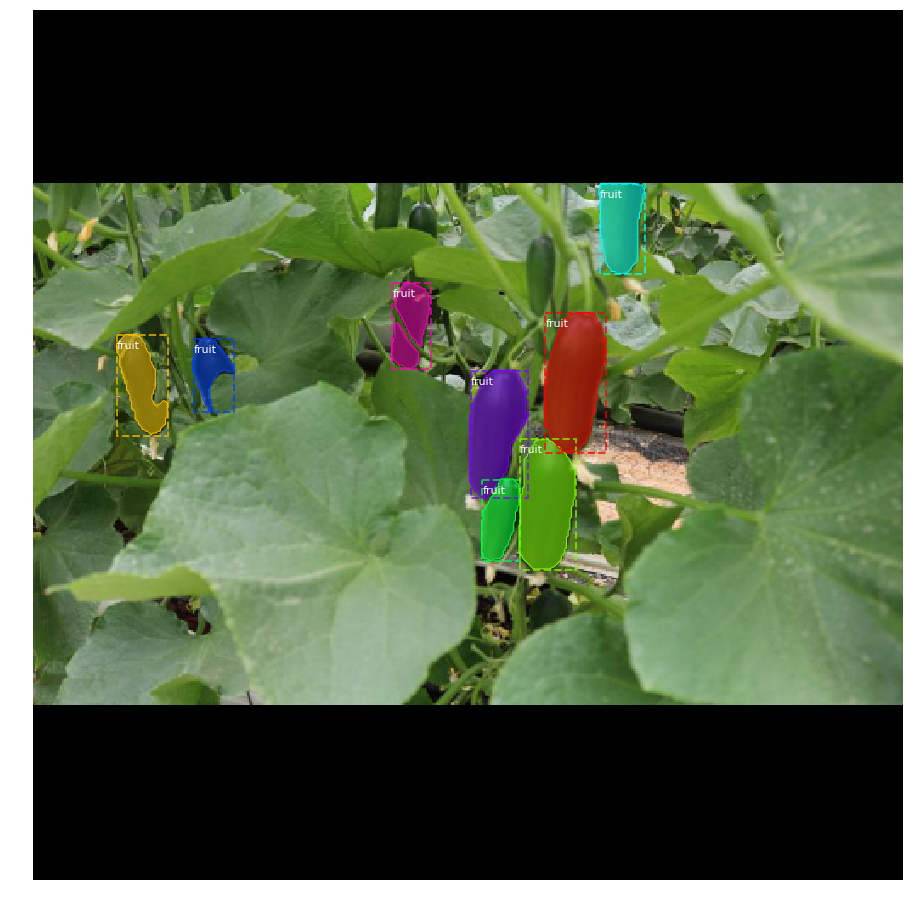

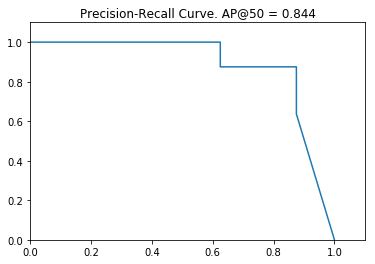

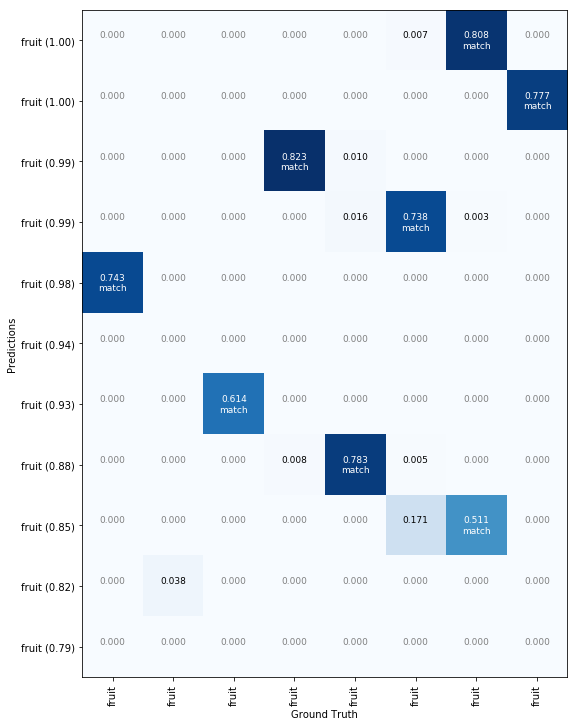

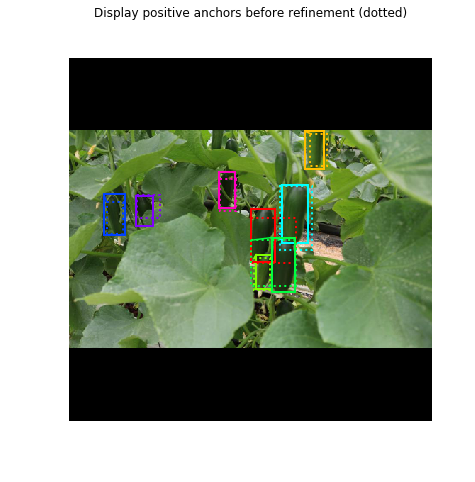

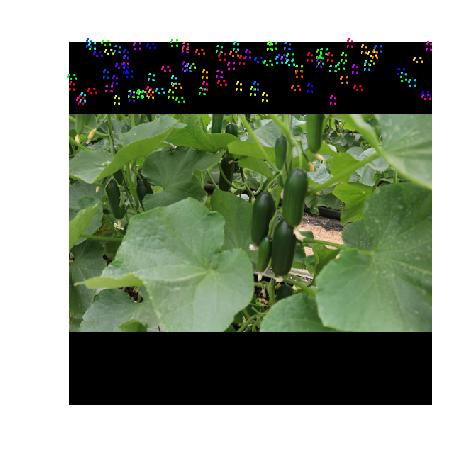

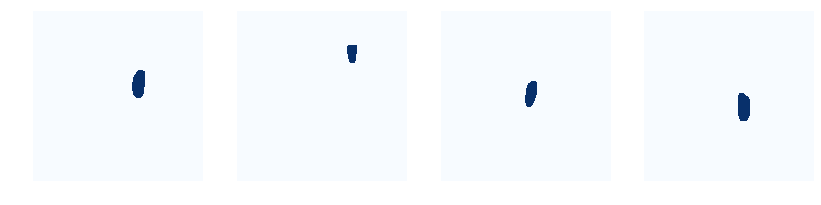

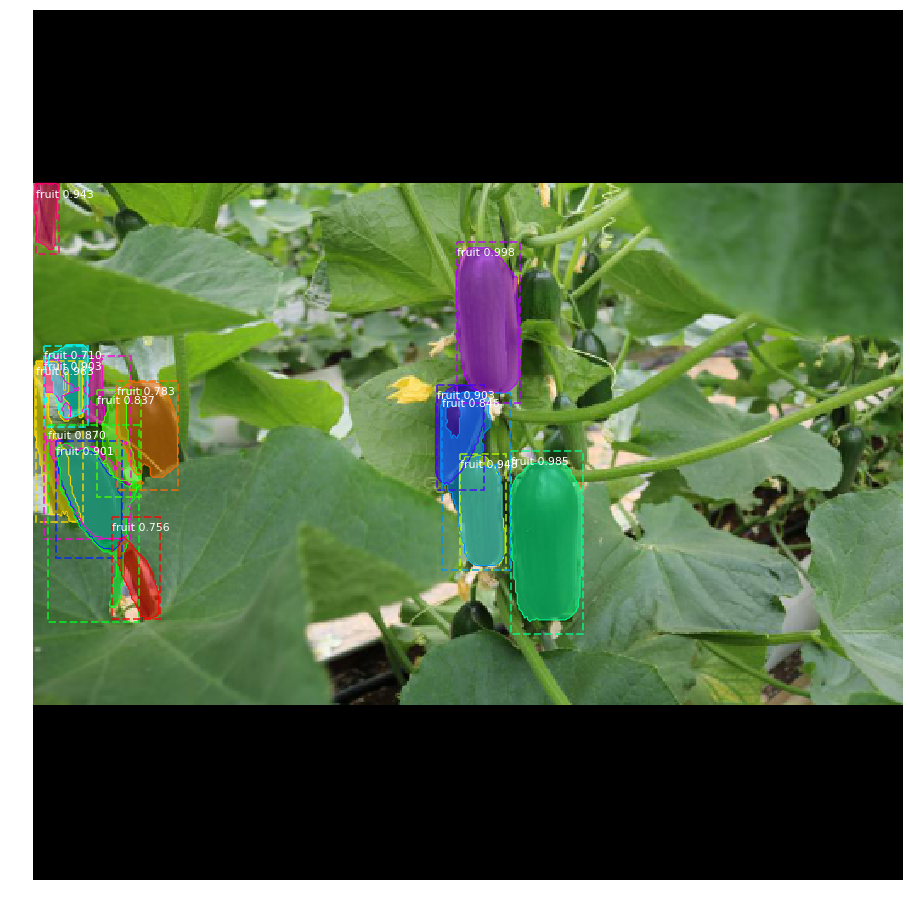

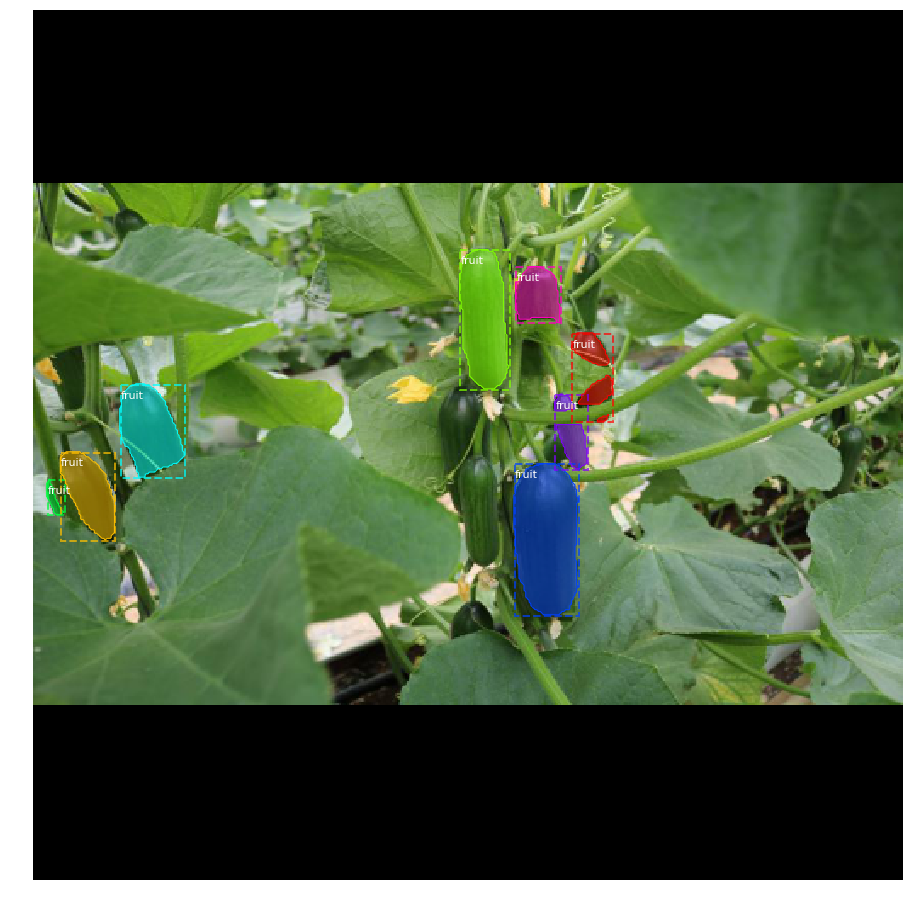

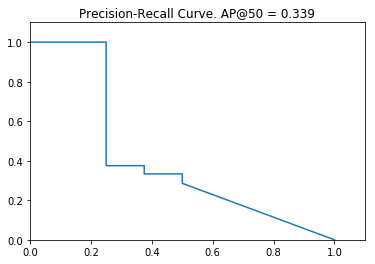

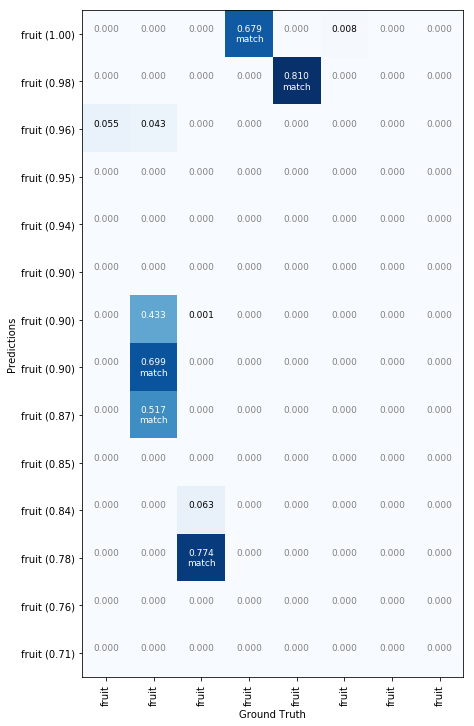

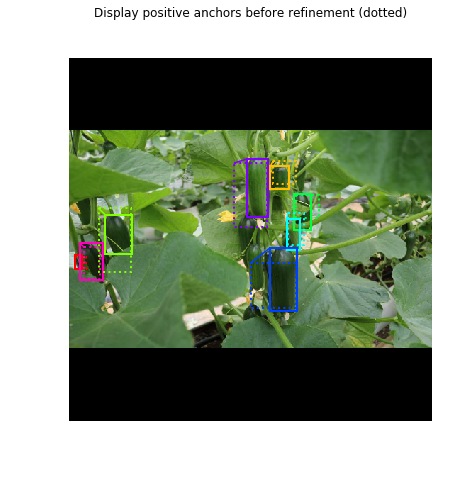

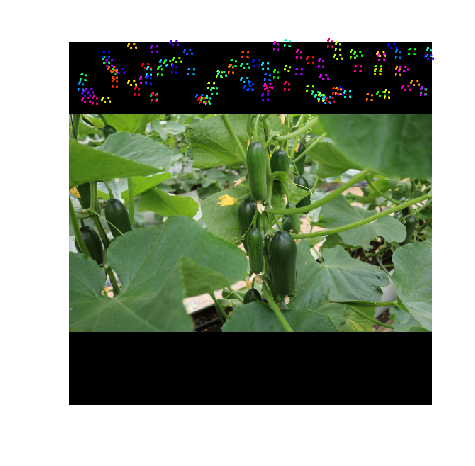

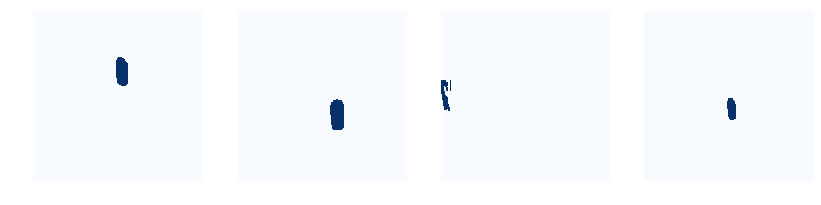

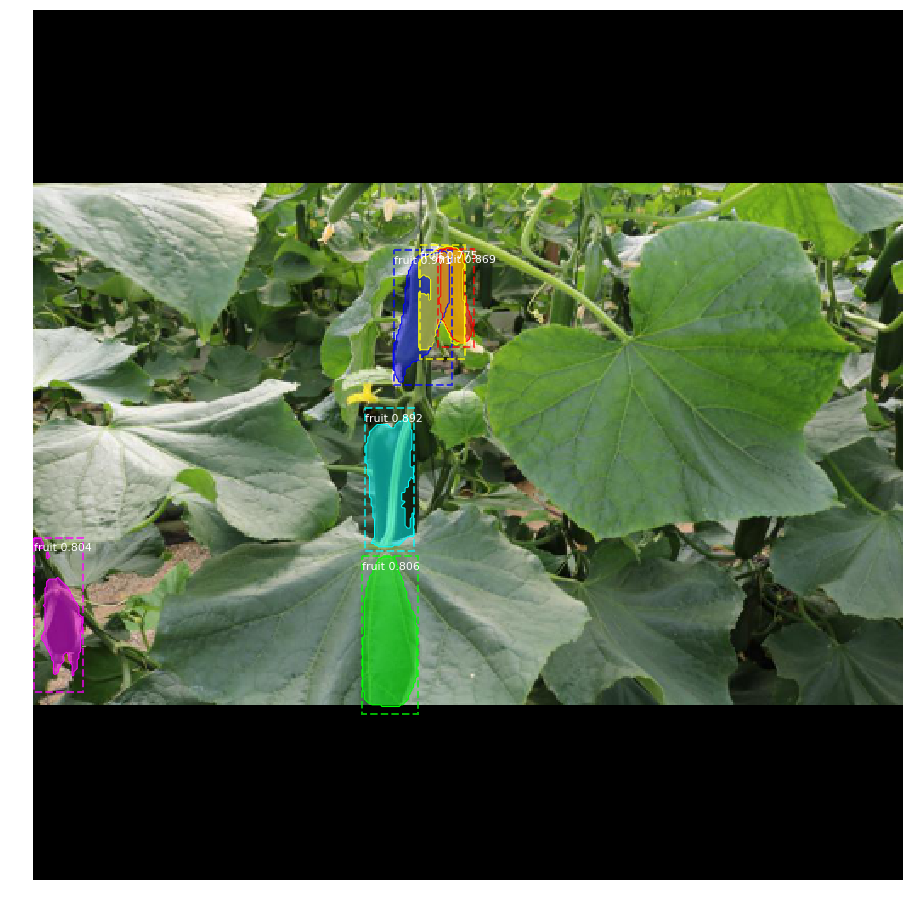

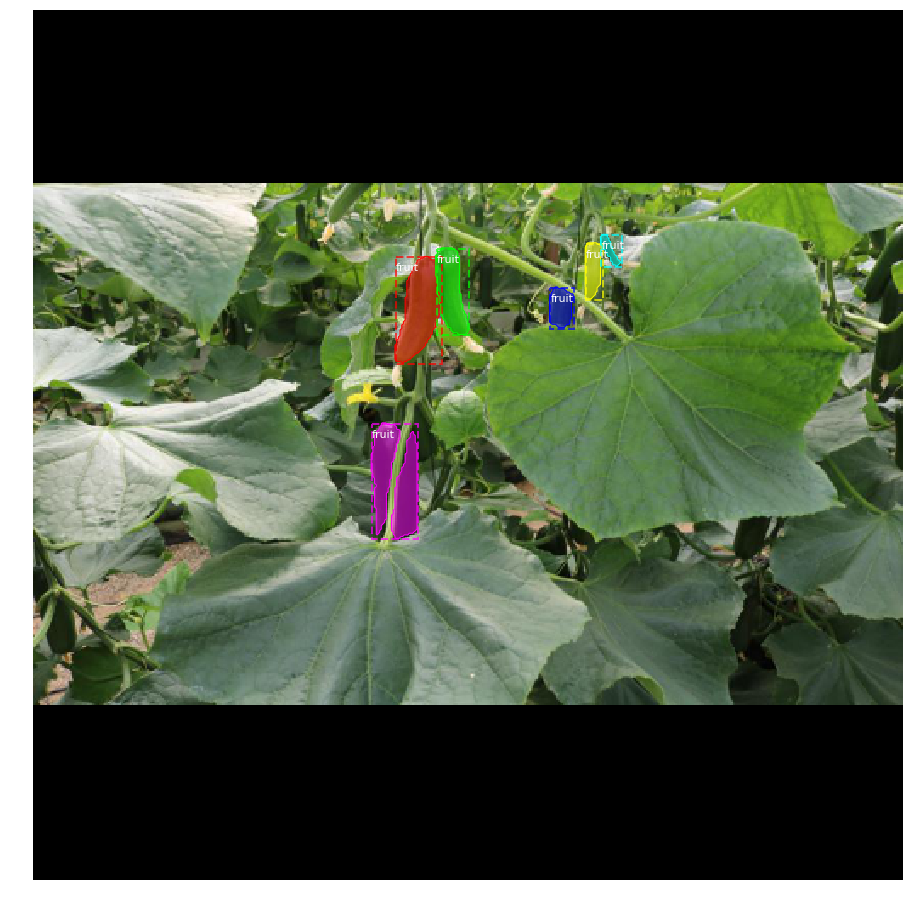

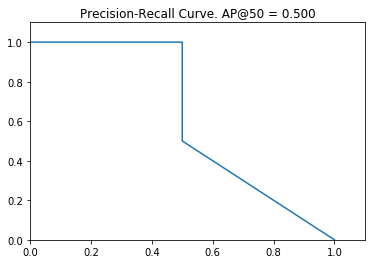

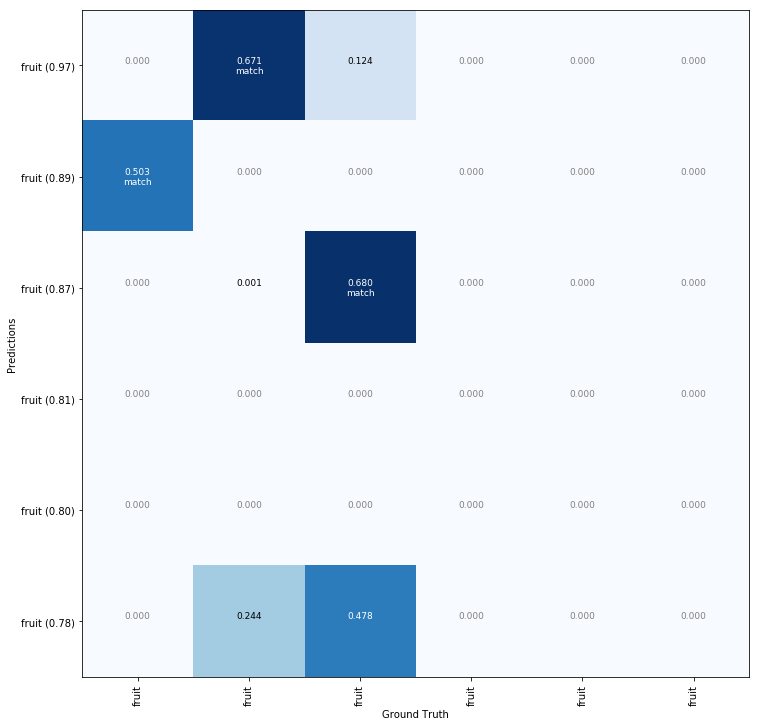

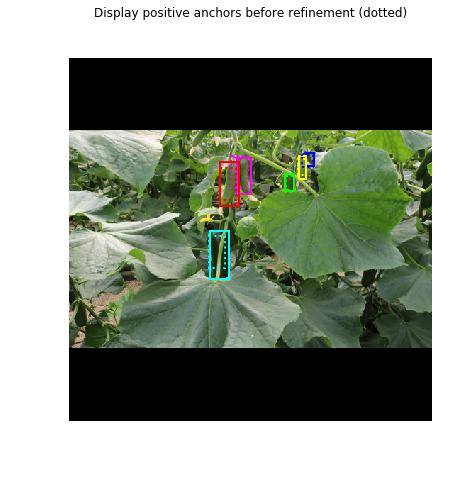

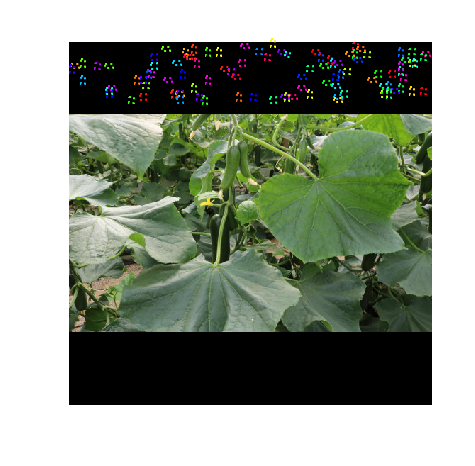

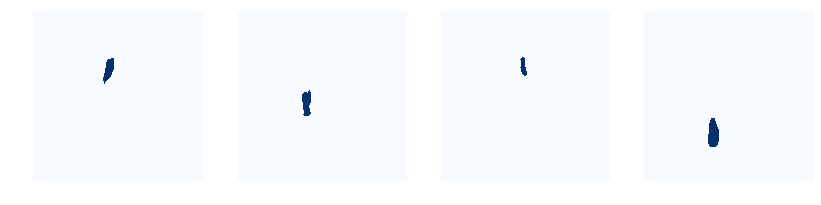

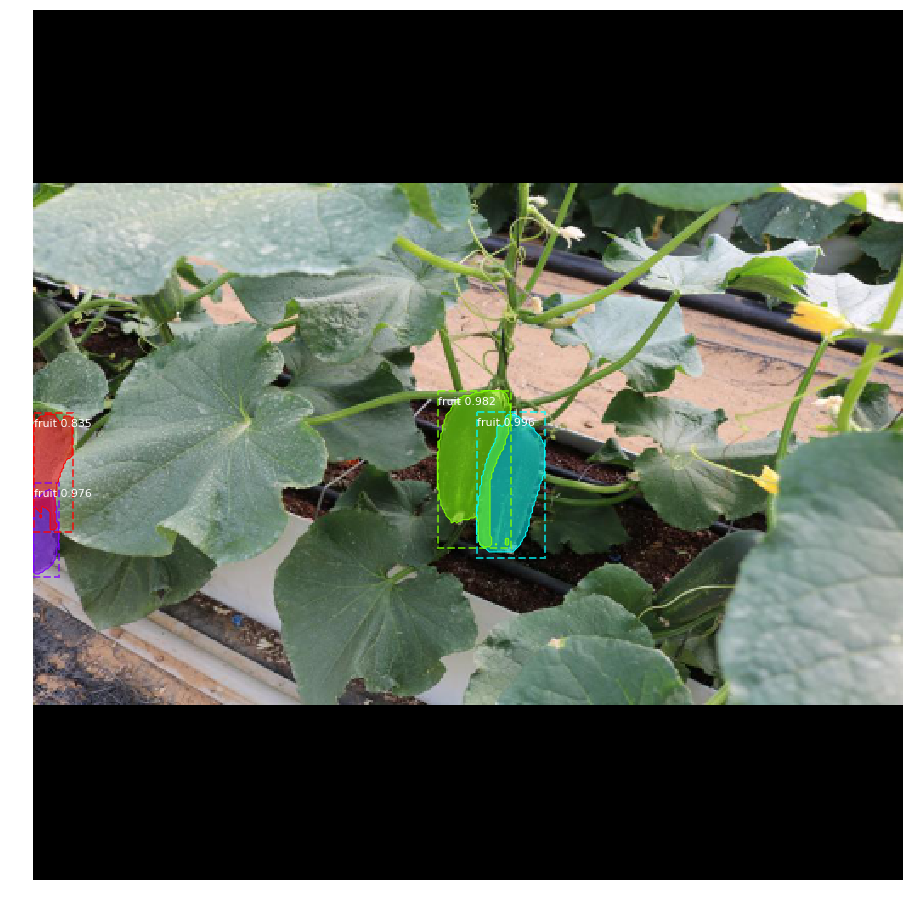

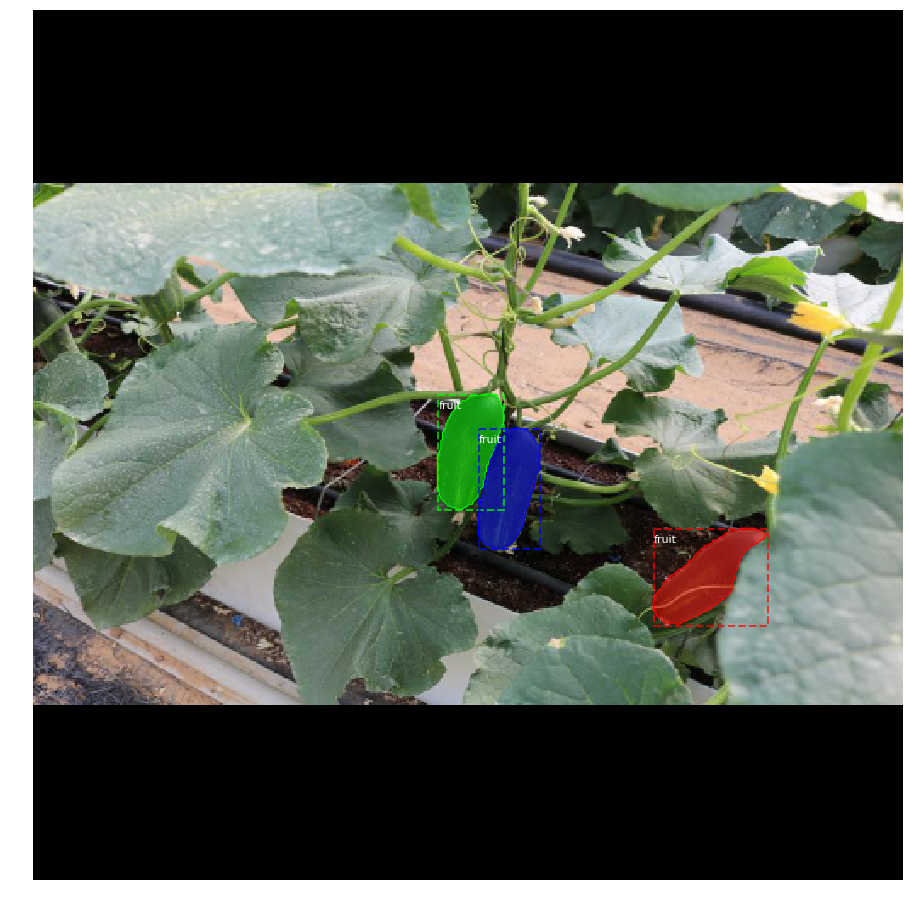

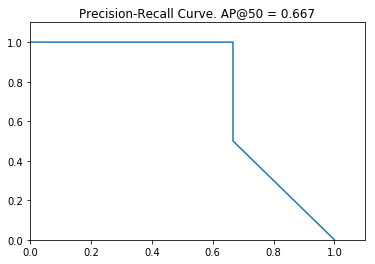

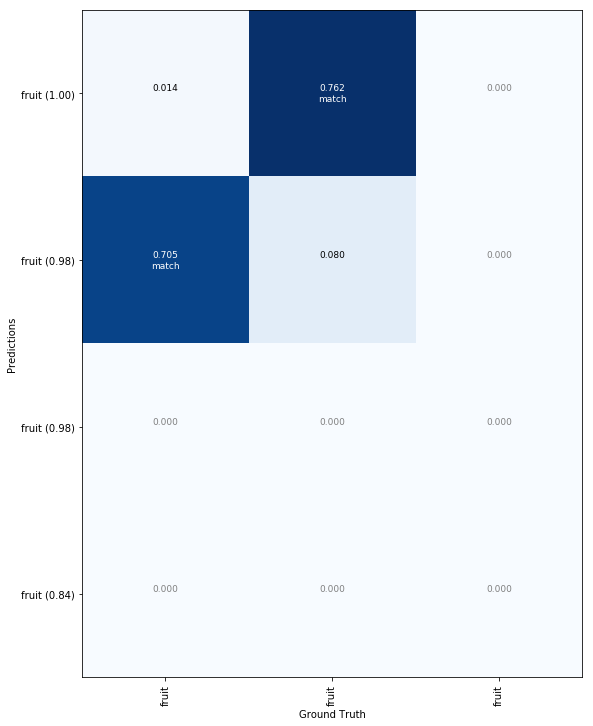

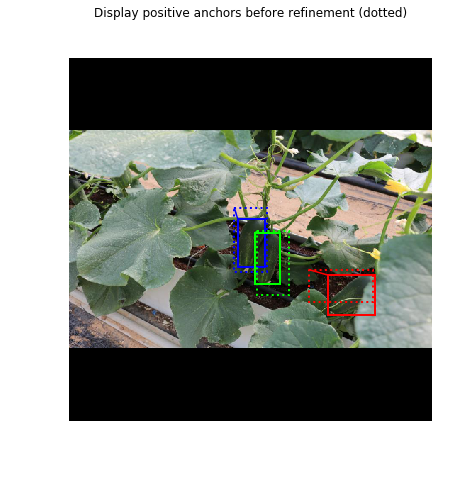

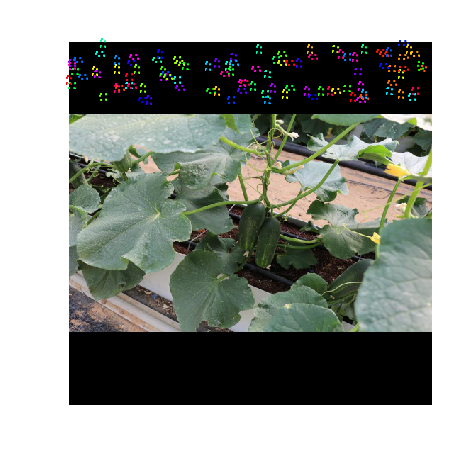

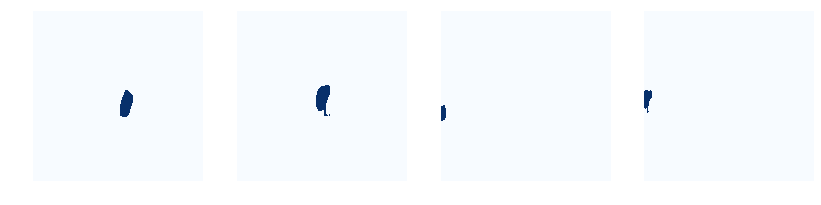

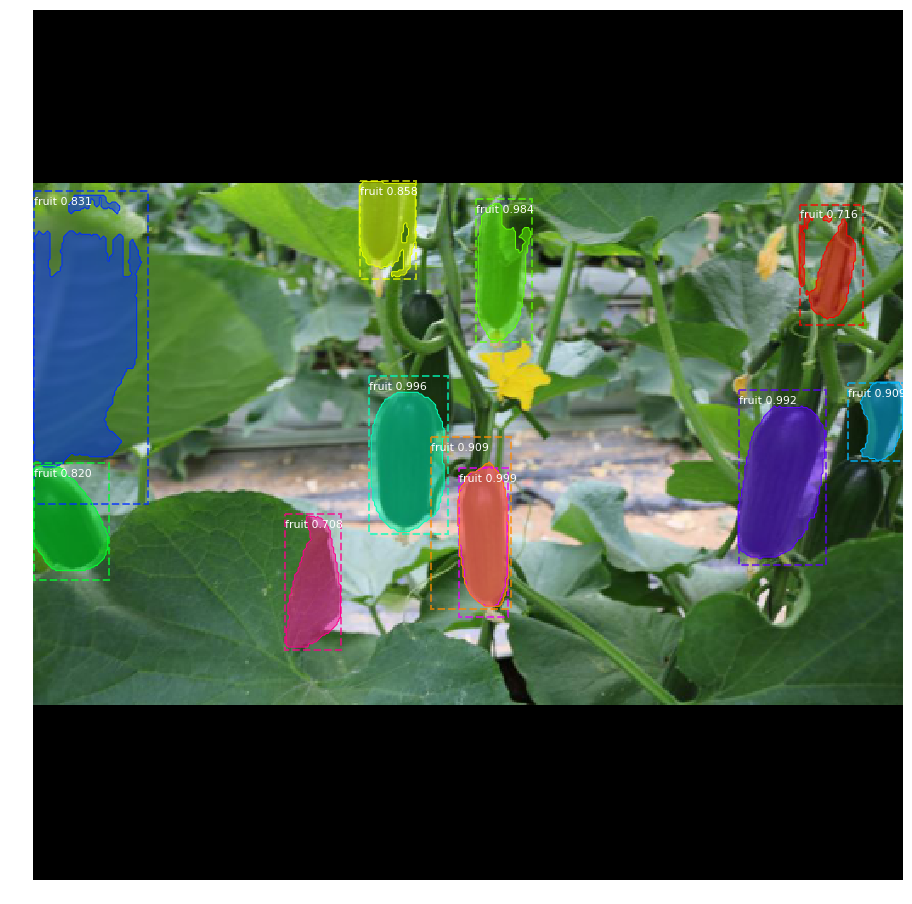

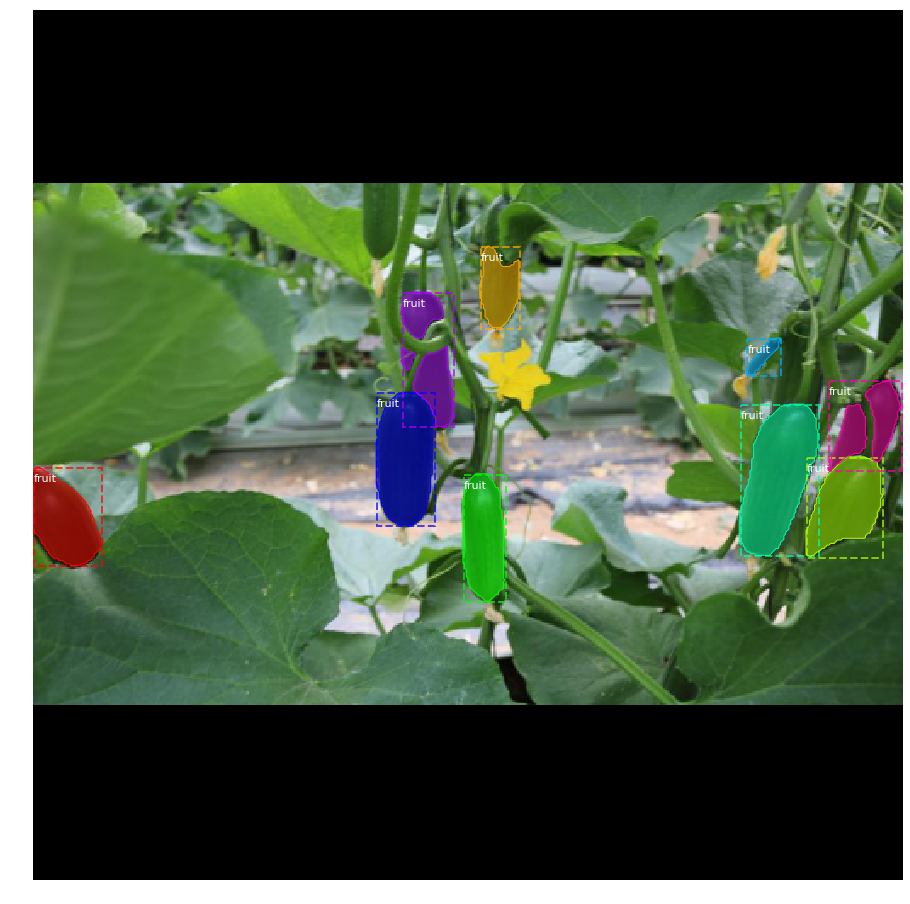

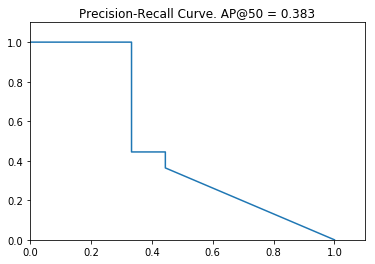

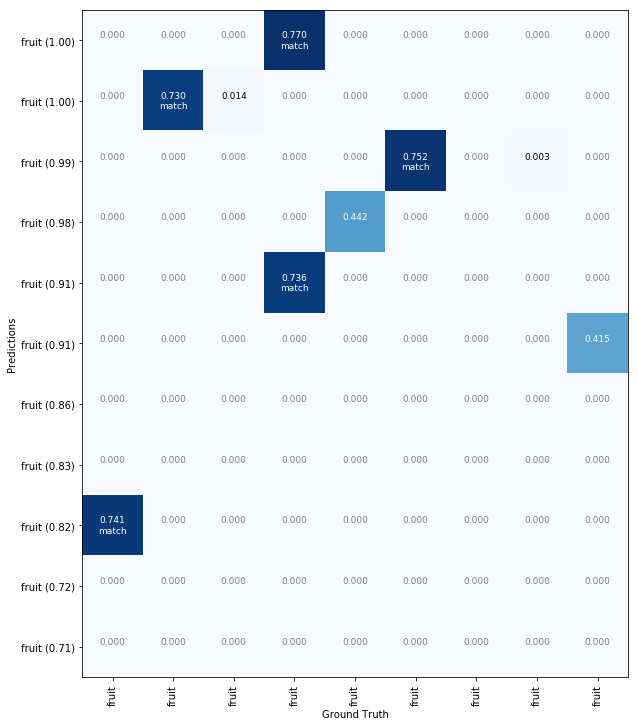

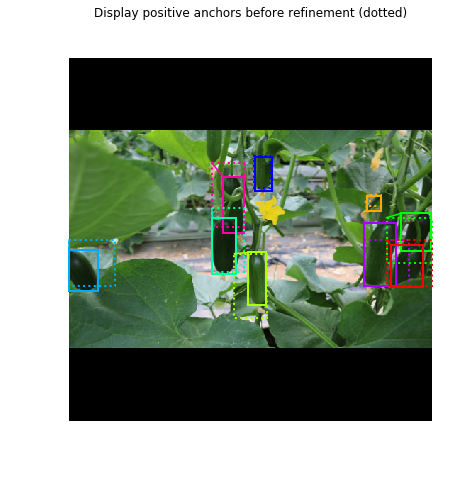

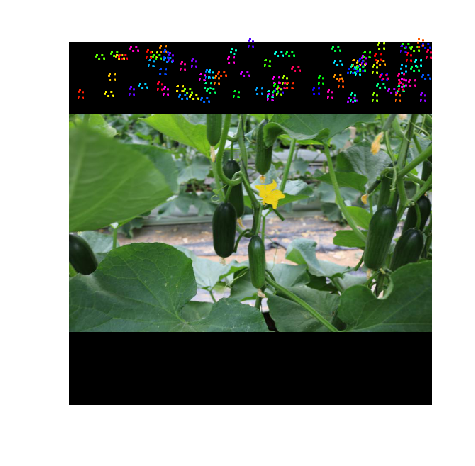

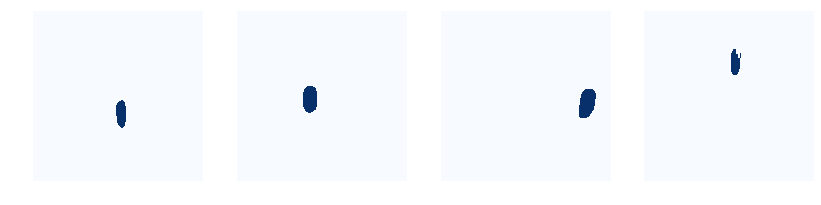

In [31]:
# DISPLAY_INSTANCES
#create container directories per function calls from Visualize module
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/display_instances")
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/plot_precision_recall")
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/plot_overlaps")
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/draw_boxes")
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/masks_detections")
# os.mkdir(cucuPaths.visualizeEvaluationsDir + "/activationsImages")

# in future we want to generate from dataset_test!
dataset = dataset_val

n = 5
image_ids = np.random.choice(dataset.image_ids, n)
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                        dataset.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
#     ax = get_ax(1)
    r = results[0]
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], title="Predictions", savePath=None)
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], savePath=None)

    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    # Load random image and mask.
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
    mask = gt_mask
    class_ids = gt_class_id
    bbox = gt_bbox
    # Compute Bounding box
#     bbox = utils.extract_bboxes(mask)

    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, savePath=None)

    # Draw precision-recall curve
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                            r['rois'], r['class_ids'], r['scores'], r['masks'])
    visualize.plot_precision_recall(AP, precisions, recalls, savePath=None)

    # Grid of ground truth objects and their predictions
    visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names, savePath=None)
    
    # Generate RPN trainig targets
    # target_rpn_match is 1 for positive anchors, -1 for negative anchors
    # and 0 for neutral anchors.
    target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
        image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
    log("target_rpn_match", target_rpn_match)
    log("target_rpn_bbox", target_rpn_bbox)

    positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
    negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
    neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
    positive_anchors = model.anchors[positive_anchor_ix]
    negative_anchors = model.anchors[negative_anchor_ix]
    neutral_anchors = model.anchors[neutral_anchor_ix]
    log("positive_anchors", positive_anchors)
    log("negative_anchors", negative_anchors)
    log("neutral anchors", neutral_anchors)

    # Apply refinement deltas to positive anchors
    refined_anchors = utils.apply_box_deltas(
        positive_anchors,
        target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
    log("refined_anchors", refined_anchors, )
    # Display positive anchors before refinement (dotted) and
    # after refinement (solid).
    visualize.draw_boxes(image, boxes=positive_anchors,title="Display positive anchors before refinement (dotted)", refined_boxes=refined_anchors, ax=get_ax(),\
                        savePath=cucuPaths.visualizeEvaluationsDir + "/draw_boxes/" + "draw_boxes_beforeAndAfterRefine_" + "image_" + str(image_id) +".png")

    # asher todo: this module stilll doesn't work
    # Run RPN sub-graph
    pillar = model.keras_model.get_layer("mrcnn_bbox").output  # node to start searching from

    # TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
    nms_node = model.ancestor(model.keras_model.get_layer("mrcnn_bbox").output, "ROI/rpn_non_max_suppression:0")
    if nms_node is None:
        nms_node = model.ancestor(model.keras_model.get_layer("mrcnn_bbox").output, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
    # if nms_node is None: #TF 1.9-1.10
    #     nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

    rpn = model.run_graph([image], [
        ("mrcnn_bbox", model.keras_model.get_layer("mrcnn_bbox").output),
        # ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
        # ("refined_anchors", model.ancestor(pillar, "mrcnn_bbox_fc")),
        # ("refined_anchors_clipped", model.ancestor(pillar, "RPN/ROI/refined_anchors_clipped:0"))
        # ,("post_nms_anchor_ix", nms_node)
        # ,("rois", model.keras_model.get_layer("TrainGroundTruths/proposal_targets/rois").output),
    ])
    # Show top anchors by score (before refinement)
    limit = 100
    sorted_anchor_ids = np.argsort(rpn['mrcnn_bbox'][:,:,1].flatten())[::-1]
    visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax(),savePath=cucuPaths.visualizeEvaluationsDir + "/draw_boxes/" + "draw_boxes_topAnchorsNotRefined_" + "image_" + str(image_id) +".png")

    # Show top anchors with refinement. Then with clipping to image boundaries
    # limit = 50
    # ax = get_ax(1, 2)
    # pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
    # refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
    # refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
    # visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
    #                     refined_boxes=refined_anchors[:limit], ax=ax[0],savePath=cucuPaths.visualizeEvaluationsDir + "/draw_boxes/" + "draw_boxes_topAnchorsRefinedWithoutClip_" + "image_" + str(image_id) +".png")
    # visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1],savePath=cucuPaths.visualizeEvaluationsDir + "/draw_boxes/" + "draw_boxes_topAnchorsRefinedWithClip_" + "image_" + str(image_id) +".png")

    # Get predictions of mask head
    mrcnn = model.run_graph([image], [
        ("detections", model.keras_model.get_layer("mrcnn_detection").output),
        ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ])

    # Get detection class IDs. Trim zero padding.
    det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
    det_count = np.where(det_class_ids == 0)[0][0]
    det_class_ids = det_class_ids[:det_count]

    print("{} detections: {}".format(
        det_count, np.array(dataset.class_names)[det_class_ids]))
    # Masks
    det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
    det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] for i, c in enumerate(det_class_ids)])
    det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)for i, m in enumerate(det_mask_specific)])
    log("det_mask_specific", det_mask_specific)
    log("det_masks", det_masks)
    visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none", savePath=cucuPaths.visualizeEvaluationsDir + "/masks_detections/" + "masks_detections_" + "image_" + str(image_id) +".png" )

#     # Get activations of a few sample layers
#     activations = model.run_graph([image], [
#         ("input_image",        model.keras_model.get_layer("input_image").output),
#         ("res2a_out",          model.keras_model.get_layer("res2a_out").output)  # for resnet100
#         # ,("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
#         # ("roi",                model.keras_model.get_layer("ROI").output),
#     ])
#     # Input image (normalized)
#     _ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))
#     plt.savefig(cucuPaths.visualizeEvaluationsDir + "/activationsImages/" + "normInputImage" + "image_" + str(image_id) +".png")
#     # Backbone feature map
#     visualize.display_images(np.transpose(activations["res2a_out"][0,:,:,:4], [2, 0, 1]), savePath=cucuPaths.visualizeEvaluationsDir + "/activationsImages/" + "activationRes2aImage" + "image_" + str(image_id) +".png")
#     # Get activations of a few sample layers
#     activations = model.run_graph([image], [
#         ("input_image",        model.keras_model.get_layer("input_image").output),
#         ("res3a_out",          model.keras_model.get_layer("res3a_out").output)  # for resnet100
#         # ,("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
#         # ("roi",                model.keras_model.get_layer("ROI").output),
#     ])
#     # Input image (normalized)
#     _ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))
#     plt.savefig(cucuPaths.visualizeEvaluationsDir + "/activationsImages/" + "normInputImage" + "image_" + str(image_id) +".png")
#     # Backbone feature map
#     visualize.display_images(np.transpose(activations["res3a_out"][0,:,:,:4], [2, 0, 1]), savePath=cucuPaths.visualizeEvaluationsDir + "/activationsImages/" + "activationRes3aImage" + "image_" + str(image_id) +".png")

In [33]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.3788461556037267
